# Практическое задание 4 

# Мультиязычный тематический поиск

## курс "Математические методы анализа текстов"


### ФИО: <впишите>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_data = '/content/drive/MyDrive/Colab Notebooks/Анализ текстов/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Введение

### Постановка задачи:

В этом задании вам предстоит сделать свою небольшую мультиязычную поисковую систему. Проще всего строить мультиязычные системы, имея "параллельные" данные: словари или корпуса параллельных текстов. 

В задании необходимо, имея англо-русскую и агло-испанскую коллекции, обучить модель поиска модель поиска испанских текстов по русским.

Решение этого задания будет основано на тематическом моделировании, а именно подходе аддитивной регуляризации.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [bigartm](http://bigartm.org/)
 - [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)
 - [nltk](http://www.nltk.org/)


### Данные

Данные — записи выступлений конференции TED Talks на трёх языках. 

Все данные содержатся в архиве `ted_collection`. В папке содержится три подпапки `/en`, `/ru` и `/es`, каждая из которых соответствует коллекции для отдельного языка. Папка `parallel_info`  содержит информацию о связях документов между коллекциями. Файл `titles_file.json` содержит информацию о заголовках документов английской коллекции.

Ссылка для скачивания данных: [ссылка на гугл диск](https://drive.google.com/file/d/1B3kDfISvWnVpEet_CDa6oLNp028mEak-/view)

#### Импорт важных библиотек

In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python
!pip install bigartm

In [ ]:
# считывание
import os
import glob
import json

# предобработка
import pymorphy2
import nltk
import re

# тематическое моделирование
import artm

# change log style for artm
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

# прочее 
import numpy as np

#### Несколько важных промежуточных функций

In [ ]:
# загрузка коллекции
from lab4_utils import load_collection

# загрузка информации о параллельных документах
from lab4_utils import load_parallel_documents_info

# запись vowpal wabit файла специального формата
from lab4_utils import write_vw_lab4

# подсчёт позиции в выдаче переводов текстов
from lab4_utils import get_indexes_of_relevant_documents

## Предобработка данных (3 балла)

Перед тем как начать моделировать, необходимо предобработать данные. 

Заметим, что для английского языка некоторые этапы обработки не оказывают сильного влияния на модель (например, лемматизация). В русском языке одному слову может соответствовать огромное количество различных форм, поэтому без лемматизации невозможно получить модель с хорошим качеством.

#### Предобработка русских текстов


Считываем коллекцию:

In [43]:
RU_DATA_PATH = PATH_data + 'ted_collection/ru'
ru_collection = load_collection(RU_DATA_PATH, verbose=True)

Total number of documents: 2731

Some document examples: 
	Электроэнергия для освещения этого зала была произведена всего несколько секунд назад. Потому что де...
	Как о нас будут вспоминать через 200 лет? Я живу в маленьком городке Принстон, в Нью Джерси, где каж...
	Когда я был маленьким, я очень любил играть в прятки. Однажды я решил, что, взобравшись на дерево, н...
	Был ли в вашей жизни момент, настолько болезненный и приводящий в смятение, что единственное, чего в...
	Я снял фильм, который невозможно было снять. Но я не знал, что это невозможно, именно поэтому мне и ...

Some file names examples: 
	ru_2672
	ru_2633
	ru_264
	ru_265
	ru_2631


Выведите полностью несколько документов. Подумайте, какую информацию из них можно удалить на этапе предобработки, не ухудшив качество решения задачи.

In [ ]:
print(ru_collection['ru_1014'])
print()
print(ru_collection['ru_1016'])
print()

Аромат, который вы почувствуете, в таком виде вам больше нигде не встретится. Это аромат под названием Beyond Paradise, он есть в любом магазине страны. Однако здесь он был разделен на составные части компанией Estée Lauder и парфюмером, создавшим его, — Калисой Беккер, и я очень благодарен им за это. Он был разделен на последовательность нот и гамму.
То, что вы сейчас нюхаете — это верхняя нота. Затем идет так называемая сердцевина, нота сердца. Сейчас я вам покажу. Доминирующая нотка Эдем названа в честь Проекта «Эдем» в Великобритании.
Сердце, нота коры чайного дерева, на самом деле не содержит кору чайного дерева, Потому что это абсолютно запрещено.
И, наконец, база, конечная нота аромата. То, что вы нюхаете, это соединение — я спросил, сколько молекул в этом аромате, и никто мне не ответил. Поэтому я пропустил его через газовый хроматограф в моем офисе и обнаружил около 400. Поэтому то, что вы нюхаете, — это несколько сотен молекул, парящих в воздухе и сталкивающихся с вашим носом

В конце каждого документы пишется специфичная информация, которую можно удалить

In [ ]:
spec_info = '(Аплодисменты) TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project. © TED Conferences, LLC. All rights reserved.'

for name in ru_collection.keys():
  ru_collection[name] = ru_collection[name][: -len(spec_info)]

Помимо удаления специфичной информации, вам необходимо провести для русского языка следующие шаги предобработки :

1. Приведение документов к нижнему регистру.

2. Удаление всех символов кроме букв.
    1. Для некоторых способов выделения коллокаций (см. бонусную часть), может быть полезна информация о знаках препинания. Также она полезна при необходимости строить синтаксический разбор предложения.
    2. Вам может помочь функция sub из библиотеки re.
3. Токенизация документов.
    1. Воспользуйтесь стандартным методом .split, функцией split из библиотеки re или одним из токенайзеров библиотеки nltk.
4. Лемматизация документов.
    1. Воспользуйтесь библиотекой pymorphy2
    2. Шаги 3 и 4 можно выполнить вместе, воспользовавшись библиотекой mytem (или её обёрткой на python pymystem)
5. Удаление стоп-слов
    1. Базовый список стоп слов можно получить из модуля nltk.corpus

После выполнения всех шагов сохраните результат в словарь аналогичный ru_collection (ключи - названия файлов, значения - предобработанный документ в формате str).



In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def preproces(documents, language):
    stop_words = stopwords.words(language)

    if language == 'russian':
        lemmatizer = pymorphy2.MorphAnalyzer()
    elif language == 'english':
        lemmatizer = WordNetLemmatizer()
    elif language == 'spanish':
        lemmatizer = nltk.stem.SnowballStemmer('spanish')
    
    for name in tqdm(documents.keys()):
        documents[name] = documents[name].lower()

        documents[name] = re.sub(r'[^\w\s]','', documents[name])
        documents[name] = re.sub(r'[0-9]','', documents[name])
        
        words = word_tokenize(documents[name])
        if language == 'russian':
            words = [lemmatizer.parse(w)[0].normal_form for w in words]
        elif language == 'english':
            words = [lemmatizer.lemmatize(w) for w in words]
        elif language == 'spanish':
            words = [lemmatizer.stem(w) for w in words]
        
        words = [w for w in words if not w in stop_words]
        documents[name] = ' '.join(words)
    return documents

In [ ]:
ru_collection = preproces(ru_collection, language = 'russian')

/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
100%|██████████| 2731/2731 [18:04<00:00,  2.52it/s]


Проанализируйте несколько предобработанных документов. Отметьте, какие неточности работы алгоритмов вы заметили, и как они могут повлиять на итоговую модель.

In [ ]:
print(ru_collection['ru_1014'])
print()
print(ru_collection['ru_1016'])
print()

аромат который почувствовать вид большой нигде встретиться это аромат название beyond paradise любой магазин страна однако раздельный составной часть компания estée lauder парфюмер создать калиса беккер очень благодарный это раздельный последовательность нота гамма нюхать это верхний нота затем идти называть сердцевина нота сердце показать доминировать нотка эдем назвать честь проект эдем великобритания сердце нота кора чайный дерево дело содержать кора чайный дерево это абсолютно запретить база конечный нота аромат нюхать это соединение спросить сколько молекула это аромат никто ответить поэтому пропустить газовый хроматограф офис обнаружить около поэтому нюхать это несколько сотня молекула парить воздух сталкиваться ваш нос думать впечатление субъективный всё нюхать примерно самый запах известный человек воспринимать поразный это парфюмерия доказывать это неправда это искусство верно пока запах доноситься позволить рассказать история идея всё нюхать состоять атом который находиться о

#### Предобработка английских текстов

Считываем коллекцию:

In [ ]:
EN_DATA_PATH = PATH_data + 'ted_collection/en'
en_collection = load_collection(EN_DATA_PATH, verbose=True)

Total number of documents: 2856

Some document examples: 
	Beau Lotto: So, this game is very simple. All you have to do is read what you see. Right? So, I'm go...
	I am a climate scientist, and I hate weather. I have spent too much time in California, and I strong...
	I have to tell you, it's more than a little intimidating being up here, an old American guy trying t...
	I'm the weekly tech critic for the New York Times. I review gadgets and stuff. And mostly what good ...
	One winter morning, a couple of years ago, I was driving to work in Johannesburg, South Africa, and ...

Some file names examples: 
	en_2706
	en_2667
	en_2687
	en_2686
	en_2676


Проведите все этапы предобработки для английского языка (шаг 4 опционален, можно использовать WordNetLemmatizer из nltk):

In [ ]:
spec_info = '(Applause) TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project. © TED Conferences, LLC. All rights reserved.'

for name in en_collection.keys():
  en_collection[name] = en_collection[name][: -len(spec_info)]

en_collection = preproces(en_collection, language = 'english')

100%|██████████| 2856/2856 [00:58<00:00, 49.09it/s]


#### Предобработка испанских текстов 

Считываем коллекцию:

In [ ]:
ES_DATA_PATH = PATH_data + 'ted_collection/es'
es_collection = load_collection(ES_DATA_PATH, verbose=True)

Total number of documents: 2809

Some document examples: 
	Estoy aquí para hablarles de la verdadera búsqueda de vida extraterrestre. No de pequeños humanoides...
	Debo confesar que estar aquí arriba es algo más que intimidante: un hombre grande como yo, estadouni...
	Períodos. Sangre. Menstruación. Burdo. Secreto. Oculto. ¿Por qué? Un proceso biológico natural por e...
	(Aplauso)
Es un verdadero honor estar aquí esta noche, y me alegra haberme quedado aquí escuchando p...
	Ya conocen la verdad de lo que voy a decir. Creo que la noción de que la desigualdad es divisiva y c...

Some file names examples: 
	es_2638
	es_2687
	es_2657
	es_2664
	es_2651


Проведите все этапы предобработки для испанского языка (шаг 4 опционален, можно использовать SpanishStemmer из nltk). 

**Замечание.** Регулярное выражение \w из библиотеки re позволяет выделять буквы (в том числе буквы испанского алфавита).

In [ ]:
spec_info = '(Aplausos) TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project. © TED Conferences, LLC. All rights reserved.'

for name in es_collection.keys():
  es_collection[name] = es_collection[name][: -len(spec_info)]

es_collection = preproces(es_collection, language = 'spanish')

100%|██████████| 2809/2809 [02:49<00:00, 16.62it/s]


#### Дополнительная предобработка

Библиотека BigARTM имеет собственный формат документов для обработки, называемый батчами. Самый простой способ создать батчи из коллекции файлов - сконвертировать в батчи vowpal wabbit файл с коллекцией (https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format). 

Тематические модели работают с мешком слов, поэтому в vowpal wabbit файле можно не хранить информацию о порядке слов в документе.

Чтобы обучить мультиязычную модель, мы будем использовать апарат модальностей тематической модели. Каждому языку будет соответствовать своя модальность (`@english`, `@russian` и `@spanish` в vowpal wabbit файле). 

Для экспериментов нам понадобится два файла. Один будет содержать информацию о параллельных документов, а другой нет. В втором файле каждая строчка соответствует конкретному документу. В первом файле, если у документа есть параллельный, он будет располагаться на этой же строчке в рамках другой модальности.

Весь код для сохранения файла в vowpal wabbit формате уже написан, вам только необходимо правильно воспользоваться функцией. В частности, проследите, чтобы в ваших документах не содержалось символов ':', '|' и '@'.

В файлах en_ru_match.txt и en_es_match.txt содержится информация о том, какие документы являются параллельными. 

In [ ]:
en_ru_parallel_docs = load_parallel_documents_info(PATH_data + 'ted_collection/parallel_info/en_ru_match.txt')
en_es_parallel_docs = load_parallel_documents_info(PATH_data + 'ted_collection/parallel_info/en_es_match.txt')

NameError: ignored

Воспользуйтесь функцией write_vw_lab4, чтобы сохранить данные в нужном формате:

In [ ]:
# vowpal wabbit файлы с коллекцией
DATA_PATH_PARALLEL = PATH_data + 'ted_collection/collection_parallel.vw'
DATA_PATH_MONO = PATH_data + 'ted_collection/collection_mono.vw'

write_vw_lab4(
    DATA_PATH_PARALLEL,
    en_collection,
    ru_collection,
    es_collection,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=True
)


write_vw_lab4(
    DATA_PATH_MONO,
    en_collection,
    ru_collection,
    es_collection,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=False
)

## Базовая моноязычная тематическая модель (2 балла)

Теорию тематического моделирования можно узнать из соответствующей лекции курса.

Научиться пользоваться bigartm легче всего по гайду из документации [ссылка](http://docs.bigartm.org/en/stable/tutorials/python_userguide/index.html).

#### Подготовка к моделированию

Чтобы преобразовать полученный vowpal wabbit файл в батчи, можно воспользоваться стандартным классом BatchVectorizer. Объект этого класса принимает на вход адрес папки с батчами или файл vowpal wabbit, а затем подаётся на вход для обучения методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

В этой части экспериментов, вам предлагается построить моноязычную тематическую модель только для английского языка, поэтому для обучения используйте файл DATA_PATH_MONO.

In [ ]:
# папка с батчами
BATCHES_PATH_MONO = PATH_data + 'ted_collection/batches_mono'

In [ ]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_MONO + '/*.batch'))) < 1:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=DATA_PATH_MONO, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MONO)
else:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=BATCHES_PATH_MONO,
                                                 data_format='batches')

Словарь – это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [ ]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MONO)

Словарь в том числе отвечает за то, на какие токены будет настраиваться модель. Редкие слова не оказывают влияние на модель, поэтому их можно удалить используя метод .filter.

In [ ]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=304087c9-fb63-49b4-8227-f32ee871733e, num_entries=51380)

#### Обучение модели

Пришло время приступить к моделированию! Начнём с простой одноязычной модели PLSA. Будем учитывать только модальность @english в документах коллекции. Так как коллекция небольшая, используйте небольшое число тем 30-50.

Параметр theta_columns_naming='title' отвечает за именование документов лейблами из vowpal wabbit формата при получении матрицы $\Theta$ (иначе они будут нумероваться в порядке появления в коллекции).

In [ ]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1})

model.initialize(dictionary)

Класс artm.ARTM поддерживает различные встроенные метрики качества. Добавьте метрики измерения перплексии, разреженности $\Phi$, разреженности $\Theta$ и счётчик топ слов. Не забудьте, что метрики должны соответствовать только модальности @english!

In [ ]:
model.scores.add(artm.PerplexityScore(name='перплексия', dictionary = dictionary))
model.scores.add(artm.SparsityPhiScore(name = 'разреженность_фи', class_id = '@english'))
model.scores.add(artm.SparsityThetaScore(name = 'разреженность_тета'))
model.scores.add(artm.TopTokensScore(name = 'топ_слова', num_tokens = 20, class_id = '@english', dictionary = dictionary))

Проведите обучение модели с помощью метода fit_offline. Подберите необходимое число операций для сходимости в зависимости от значения перплексии:

In [ ]:
model.fit_offline(batch_vectorizer = batch_vectorizer_mono, num_collection_passes = 10)

Pass: 100%|██████████| 10/10 [01:07<00:00,  6.79s/it]


Выведите график изменения перплексии в зависимости от итерации алгоритма, чтобы мы знали, что ваш алгоритм точно сошёлся :)

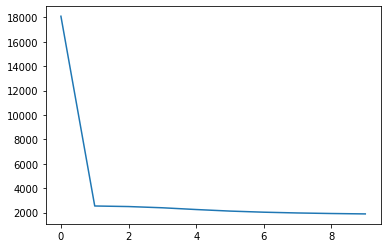

In [ ]:
plt.plot(model.score_tracker["перплексия"].value)

#### Интерпретация результатов

Основная особенность тематических моделей — интерпретируемость получаемых матриц $\Phi$ и $\Theta$. С помощью $\Phi$ для каждой темы можно узнать топ-слова, а с помощью $\Theta$ для каждой темы можно узнать топ-документы. 
Для того, чтобы получить матрицу $\Theta$, используйте метод .transform.

Для каждой темы выведите топ её слов ($\geq 20$) и топ заголовкой её документов ($\geq 5$). Попробуйте интерпертировать полученные темы, действительно ли темы получаются осмысленными?

In [ ]:
file_name_to_title = {}
with open(PATH_data + 'ted_collection/titles_file.json') as f:
    for line in f:
        file_name_to_title.update(json.loads(line))

In [ ]:
theta = model.transform(batch_vectorizer = batch_vectorizer_mono)
phi = model.get_phi(class_ids={'@english':1})

In [ ]:
for i, topic_name in enumerate(model.topic_names):
    print(topic_name)

    top_words = list(phi[topic_name].sort_values(ascending=False)[:20].index)
    top_words = [w for w in top_words]
    print(top_words)

    top_documents = list(theta.iloc[i].sort_values(ascending=False)[:5].index)
    top_documents = [file_name_to_title[doc] for doc in top_documents]
    print(top_documents)

topic_0
['country', 'world', 'africa', 'wa', 'year', 'people', 'government', 'global', 'ha', 'like', 'also', 'african', 'china', 'need', 'aid', 'million', 'india', 'refugee', 'today', 'europe']
['Peter Eigen: How to expose the corrupt', 'Parag Khanna: Mapping the future of countries', 'Olúfẹ́mi Táíwò: Why Africa must become a center of knowledge again', 'Parag Khanna: How megacities are changing the map of the world', 'Sanjay Pradhan: How open data is changing international aid']
topic_1
['cancer', 'patient', 'care', 'health', 'doctor', 'wa', 'u', 'medical', 'like', 'disease', 'one', 'life', 'need', 'many', 'hospital', 'treatment', 'time', 'know', 'way', 'also']
['Matthias Müllenbeck: What if we paid doctors to keep people healthy?', 'Scott Williams: The hidden role informal caregivers play in health care', "David Casarett: A doctor's case for medical marijuana", 'Joshua Smith: New nanotech to detect cancer early', 'Laura Indolfi: Good news in the fight against pancreatic cancer']

В целом темы получаются осмысленными, слова дают интерпретируемое представление о теме. Проблема: в топе слов много общих слов, не относящихся к конкретной теме. Topic_0 о мире: о разных частях света, странах, Topic_1 о здоровье, в Topic_2 бизнес статьи, Topic_3 о современных технологиях.

## Мультиязычная тематическая модель (5 баллов)

В этом пункте задания вам будет необходимо обучить мультиязычную тематическую модель.

В данном пункте вы будете реализовывать модель ML-TD (MultiLingual Parallel).

* каждый язык — отдельная модальность
* $\theta_{td}$ — общая для всех параллельных документов

Таким образом на обучении все параллельные документы записываются в одну строку в vowpal wabbit файле.

Оценивать качество модели мы будем на задаче поиска перевода текста. Вам будет необходимо оценить качество трёх переводов: с русского на английский, с испанского на английский и с русского на испанский.

Поиск документов будет устроен следующим образом. Будем для документа d на языке A считать близости со всеми документами на языке B и ранжировать документы языка B по этой близости. Для каждого документа посчитаем позицию истинного перевода документа в выдаче. Итоговая метрика — медиана или среднее таких позиций по всем документам.

Выделим множества документов, для которых не было известно информации об их переводе:

In [20]:
ru_es_parallel_docs_test = load_parallel_documents_info(PATH_data + 'ted_collection/parallel_info/ru_es_match_test.txt', verbose=False)
ru_en_parallel_docs_test = load_parallel_documents_info(PATH_data + 'ted_collection/parallel_info/ru_en_match_test.txt', verbose=False)
es_en_parallel_docs_test = load_parallel_documents_info(PATH_data + 'ted_collection/parallel_info/es_en_match_test.txt', verbose=False)

Проведите подготовительный этап (создание батчей и словарей) для мультиязычной коллекции DATA_PATH_PARALLEL.

In [21]:
BATCHES_PATH_MULTI = PATH_data + 'ted_collection/batches_multi'

if len(glob.glob(os.path.join(BATCHES_PATH_MULTI + '/*.batch'))) < 1:
    batch_vectorizer_multi = artm.BatchVectorizer(data_path=DATA_PATH_MULTI, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MULTI)
else:
    batch_vectorizer_multi = artm.BatchVectorizer(data_path=BATCHES_PATH_MULTI,
                                                 data_format='batches')

Обучите мультиязычную модель и проинтерпертируйте полученные темы. Если вы всё сделали правильно, то топ-слова различных языков для одной темы должны получиться достаточно похожими.

In [38]:
model = artm.ARTM(num_topics=15,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1., '@russian': 0.5, '@spanish':0.5})

dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MULTI)
MIN_DF = 5
dictionary.filter(min_df=MIN_DF)

model.initialize(dictionary)

model.scores.add(artm.PerplexityScore(name='перплексия',dictionary=dictionary,class_ids =['@english', '@russian', '@spanish']))
model.scores.add(artm.SparsityPhiScore(name='англ_разреженность_фи',class_id = '@english'))
model.scores.add(artm.SparsityPhiScore(name='рус_разреженность_фи', class_id = '@russian'))
model.scores.add(artm.SparsityPhiScore(name='исп_разреженность_фи',class_id = '@spanish'))
model.scores.add(artm.SparsityThetaScore(name='разреженность_тета'))
model.scores.add(artm.TopTokensScore(name='англ_топ_слова',class_id = '@english',dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='рус_топ_слова',class_id = '@russian',dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='исп_топ_слова',class_id = '@spanish',dictionary=dictionary))

model.fit_offline(batch_vectorizer=batch_vectorizer_multi, num_collection_passes=100)


Pass:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:01<?, ?it/s]

Batch:   0%|          | 0/7 [00:02<?, ?it/s]

Batch:   0%|          | 0/7 [00:03<?, ?it/s]

Batch:  14%|█▍        | 1/7 [00:04<00:06,  1.01s/it]

Batch:  57%|█████▋    | 4/7 [00:09<00:03,  1.21s/it]

Batch: 100%|██████████| 7/7 [00:11<00:00,  1.04s/it]

                                                    
Pass:   1%|          | 1/100 [00:11<18:39, 11.31s/it]

Batch:   0%|          | 0/7 [00:00<?, ?it/s]

Batch:   0%|          | 0/7 [00:01<?, ?it/s]

Batch:   0%|          | 0/7 [00:02<?, ?it/s]

Batch:   0%|          | 0/7 [00:03<?, ?it/s]

Batch:  14%|█▍        | 1/7 [00:04<00:06,  1.00s/it]

Batch:  29%|██▊       | 2/7 [00:08<00:09,  1.91s/it]

Batch:  57%|█████▋    | 4/7 [00:09<00:04,  1.49s/it]

Batch: 100%|██████████| 7/7 [00:11<00:00,  1.24s/it]

                                                    
Pass:   2%|▏         | 2/100 [00:22<18:25, 11

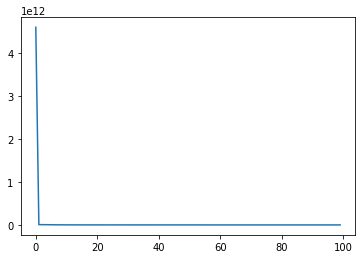

In [39]:
plt.plot(model.score_tracker["перплексия"].value)

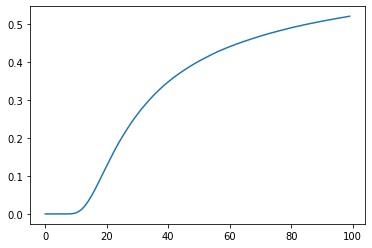

In [40]:
plt.plot(model.score_tracker["англ_разреженность_фи"].value)

Протестируйте качество на трёх задачах перевода. Добейтесь хорошего качества (медиана позиции в выдаче ~ 0, среднее ~ 10). Получить положение в выдаче переводов текстов вам поможет функция get_indexes_of_relevant_documents из модуля lab4_utils. Для того, чтобы всё работало корректно (на тесте не должна быть известна информация о параллельности документов), подавайте в качестве theta результат model.transform(batch_vectorizer_mono).

Возможные способы улучшения:
* изменять веса модальностей
* изменять количество тем, количество итераций обучения
* добавлять регуляризаторы (см. бонусную часть)
* изменять метрику для поиска ближайших документов
* добавлять шаги в предобработку (выделение колокаций)

**В первую очередь** рекомендуется подобрать количество тем (в данной задаче хорошо работает небольшое число тем - несколько десятков) и веса модальностей.

За нетривиальные подходы могут быть начислены дополнительные бонусные баллы!

In [41]:
theta = model.transform(batch_vectorizer = batch_vectorizer_multi)
phi = model.get_phi(class_ids=['@english', '@russian', '@spanish'])


Batch: 100%|██████████| 7/7 [00:09<00:00,  1.11it/s]
                                                    

In [42]:
index_ru_en, pair_ru_en = get_indexes_of_relevant_documents(theta, ru_en_parallel_docs_test)
print(f'ru_en: median = {np.median(index_ru_en)}, mean = {np.mean(index_ru_en)}')

index_ru_es, pair_ru_es = get_indexes_of_relevant_documents(theta, ru_es_parallel_docs_test)
print(f'ru_es: median = {np.median(index_ru_es)}, mean = {np.mean(index_ru_es)}')

index_es_en, pair_es_en = get_indexes_of_relevant_documents(theta, es_en_parallel_docs_test)
print(f'es_en: median = {np.median(index_es_en)}, mean = {np.mean(index_es_en)}')

ru_en: median = 0.0, mean = 11.06875
ru_es: median = 0.0, mean = 11.3775
es_en: median = 0.0, mean = 5.0675


Проведите анализ ошибок. На каких документах модель отработала лучше всего, на каких хуже всего? Как вы думаете почему?

In [44]:
worst_ru_en = index_ru_en.index(max(index_ru_en))
worst_ru_es = index_ru_es.index(max(index_ru_es))
print(ru_collection[pair_ru_en[worst_ru_en][0]])
print(ru_collection[pair_ru_es[worst_ru_es][0]])

Это портрет Мориса Дрюона, Почетного пожизненного секретаря L'Academie francaise — Французской Академии. На нём роскошное одеяние стоимостью 68 000 долларов, соответствующее статусу Французской Академии, которая устанавливает привила использования французского языка и обеспечивает его сохранение. У Французской Академии две основных задачи: составление словаря официального французского языка. Они сейчас готовят его девятое издание, работу над которым они начали в 1930 году и дошли до буквы "P" ("П"). Они также устанавливают правила словоупотребления, например, правильный термин для того, что французы называют "e-mail", а должно быть "courriel" ("электронная почта"). От французов требуют, чтобы World Wide Web называлась как "la toile d'araignee mondiale" ("Глобальная паутина"). Эти рекомендации французы с радостью игнорируют.
Итак, это одна из моделей существования языка: официально утверждаемая Академией. Но любой, кто посмотрит на язык, поймёт, что это тщетное занятие, и что язык, скор

На русско-английском переводе хуже всего модель отработала на документе с текстом об лингвистике, в котором много предложений-цитат, содержимое которых не несет никакой информации о тематике документа, но вносит свой вклад при определении темы. Между русским и испанским хуже всего модель отработала на тексте песни, наверное вследствии наличии большого количества слов, неинформативных для модели.

## Бонусная часть

#### Добавление фоновых тем (до 1 балла)

Основной инструмент улучшения качества тематической модели — регуляризация. Выделите часть тем модели как фоновые. Сглаживайте $\Theta$ для фоновых тем, разреживайте для предметных.

Проинтерпретируйте результаты. Фоновые темы должны иметь в качество топ-слов слова фоновой лексики! Удалось ли с помощью введения фоновых тем повысить качество модели?

#### Модальность n-грамм (до 2 баллов)

Для каждого языка добавьте дополнительную модальность n-грамм. n-граммы можно выделить, например, с помощью пакета Phrases из модуля Gensim. Как отразилось добавление новой модальности на интерпретируемости модели? Удалось ли с помощью введения n-грамм повысить качество модели?